## 下载整理好之后的数据集

In [1]:
pwd

'/project/train/src_repo/MMSegmentation_Tutorials/20230612'

In [6]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [7]:
rm -rf data/Watermelon87_Semantic_Seg_Mask

In [ ]:
!unzip data/Watermelon87_Semantic_Seg_Mask.zip -d data/

In [3]:
!wget https://extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com/user-36511-files/831eff32-4da6-44f1-a660-ae6a810329cf/Watermelon87_Semantic_Seg_Labelme.zip -P data/

--2023-06-14 15:20:29--  https://extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com/user-36511-files/831eff32-4da6-44f1-a660-ae6a810329cf/Watermelon87_Semantic_Seg_Labelme.zip
Resolving extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com (extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com)... 47.110.23.49
Connecting to extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com (extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com)|47.110.23.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12978831 (12M) [application/zip]
Saving to: ‘data/Watermelon87_Semantic_Seg_Labelme.zip’

Watermelon87_Semant 100%[===================>]  12.38M  9.90MB/s    in 1.3s    

2023-06-14 15:20:31 (9.90 MB/s) - ‘data/Watermelon87_Semantic_Seg_Labelme.zip’ saved [12978831/12978831]



In [5]:
!unzip data/Watermelon87_Semantic_Seg_Labelme.zip -d data/

Archive:  data/Watermelon87_Semantic_Seg_Labelme.zip
   creating: data/Watermelon87_Semantic_Seg_Labelme/
   creating: data/Watermelon87_Semantic_Seg_Labelme/images/
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/1471253631_2.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/68200_main-1.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/suika011.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/R.jpeg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/0778_02.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/piece-watermelon-isolated-white-background-top-view-95945299.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/watermelon-slices.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/watermelon-medium.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/da23-e4580.jpg  
  inflating: data/Watermelon87_Semantic_Seg_Labelme/images/R (8).jpeg  
  inflating: data/Water

In [9]:
!pip install imgviz -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 9.3 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## 转化数据集

In [9]:
!touch data/watermelon_class_names.txt

In [10]:
from pathlib import Path
import json
import math
import shutil
import random

import numpy as np
import PIL.ExifTags
import PIL.Image
import PIL.ImageDraw
import PIL.ImageOps
import cv2
import imgviz


def apply_exif_orientation(image):
    try:
        exif = image._getexif()
    except AttributeError:
        exif = None

    if exif is None:
        return image

    exif = {
        PIL.ExifTags.TAGS[k]: v
        for k, v in exif.items()
        if k in PIL.ExifTags.TAGS
    }

    orientation = exif.get('Orientation', None)

    if orientation == 1:
        # do nothing
        return image
    elif orientation == 2:
        # left-to-right mirror
        return PIL.ImageOps.mirror(image)
    elif orientation == 3:
        # rotate 180
        return image.transpose(PIL.Image.ROTATE_180)
    elif orientation == 4:
        # top-to-bottom mirror
        return PIL.ImageOps.flip(image)
    elif orientation == 5:
        # top-to-left mirror
        return PIL.ImageOps.mirror(image.transpose(PIL.Image.ROTATE_270))
    elif orientation == 6:
        # rotate 270
        return image.transpose(PIL.Image.ROTATE_270)
    elif orientation == 7:
        # top-to-right mirror
        return PIL.ImageOps.mirror(image.transpose(PIL.Image.ROTATE_90))
    elif orientation == 8:
        # rotate 90
        return image.transpose(PIL.Image.ROTATE_90)
    else:
        return image


class SegmentGenerator:
    def labelme_to_segment(self,
                           class_names_file_path,
                           image_dir_path,
                           json_dir_path,
                           output_dir_path,
                           train_data_percent):
        class_names_file_path = Path(class_names_file_path)
        image_dir_path  = Path(image_dir_path)
        json_dir_path   = Path(json_dir_path)
        output_dir_path = Path(output_dir_path)

        if output_dir_path.exists():
            shutil.rmtree(output_dir_path.as_posix())

        output_dir_path.mkdir(parents=True)

        class_names = []

        with open(class_names_file_path.as_posix(), 'r') as file_stream:
            for line in file_stream:
                line = line.strip()

                if line:
                    class_names.append(line)

        print('class_names:', class_names)

        class_name_dict = {class_name: class_index for class_index, class_name in enumerate(class_names)}

        print('class_name_dict:', class_name_dict)

        self.convert(image_dir_path,
                     json_dir_path,
                     output_dir_path,
                     class_name_dict)

        self.slplit_train_val(output_dir_path, train_data_percent)

    def convert(self,
                image_dir_path,
                json_dir_path,
                output_dir_path,
                class_name_dict):
        output_image_dir_path = output_dir_path / 'images'
        output_image_dir_path.mkdir(parents=True)
        output_mask_dir_path = output_dir_path / 'masks'
        output_mask_dir_path.mkdir(parents=True)

        json_file_paths = list(json_dir_path.glob('*.json'))

        colormap = imgviz.label_colormap()
        file_path_pairs = []
        output_file_index = 0

        for json_file_path in json_file_paths:
            # if json_file_path.stem != '045_sozai_l':
            #     continue

            if not json_file_path.suffix in ['.json']:
                warn_format = r'[Warn] Ignore json_file_path {} because it is not json file!'
                print(warn_format.format(json_file_path.as_posix()))
                continue

            with open(json_file_path.as_posix(), 'r') as file_stream:
                labelme_data = json.load(file_stream)

            image_file_path = image_dir_path / labelme_data['imagePath']

            if not image_file_path.exists():
                warn_format = r'[Warn] Ignore json_file_path {} because image_file_path {} not exist!'
                print(warn_format.format(json_file_path.as_posix(), image_file_path.as_posix()))
                continue

            if image_file_path.stem != json_file_path.stem:
                warn_format = r'[Warn] Name different between json_file_path {} and image_file_path {}!'
                print(warn_format.format(json_file_path.as_posix(), image_file_path.as_posix()))

            labelme_image_height = labelme_data['imageHeight']
            labelme_image_width  = labelme_data['imageWidth']

            origin_image = PIL.Image.open(image_file_path.as_posix())
            image_pil = apply_exif_orientation(origin_image)
            image_arr = np.array(image_pil)
            image_height, image_width = image_arr.shape[:2]

            if not (labelme_image_height == image_height and labelme_image_width == image_width):
                warn_format = r'Image height, size different between labelme {} and image {}!'
                print(warn_format.format((labelme_image_height, labelme_image_width),
                                         (image_height, image_width)))
                continue

            output_image_file_name = r'{:05}.jpg'.format(output_file_index)
            # output_image_file_name = image_file_path.with_suffix('.jpg').name
            output_image_file_path = output_image_dir_path / output_image_file_name
            image_pil.save(output_image_file_path.as_posix())
            image_pil.close()

            mask_arr = self.shapes_to_mask(image_arr.shape,
                                           labelme_data['shapes'],
                                           class_name_dict)

            # mask_pil = PIL.Image.fromarray(mask_arr.astype(np.uint8), mode='P')
            output_mask_file_path = output_mask_dir_path / output_image_file_path.with_suffix('.png').name

            # class_names = [shape['label'] for shape in labelme_data['shapes']]
            # print(set(class_names))
            # print(np.unique(mask_arr))

            # mask_pil.putpalette(colormap.flatten())
            # mask_pil.save(output_mask_file_path.as_posix())
            # mask_pil.close()
            cv2.imwrite(output_mask_file_path.as_posix(), mask_arr.astype(np.uint8))
            file_path_pair = {'mask_file_path': output_mask_file_path.as_posix(),
                              'json_file_path': json_file_path.as_posix()}

            file_path_pairs.append(file_path_pair)

            output_file_index += 1

        file_pair_path = output_dir_path / 'file_pairs.json'

        with open(file_pair_path.as_posix(), 'w') as file_stream:
            json.dump(file_path_pairs, file_stream, indent=4)


    def shapes_to_mask(self,
                        image_shape,
                        shapes,
                        class_name_dict):
        class_mask = np.zeros(image_shape[:2], dtype=np.int32)

        shapes.sort(key=lambda shape:class_name_dict[shape['label']])

        for shape in shapes:
            class_name = shape['label']
            points = shape['points']
            shape_type = shape.get('shape_type', 'polygon')

            mask = self.shape_to_mask(image_shape[:2], points, shape_type)
            class_id = class_name_dict[class_name]
            class_mask[mask] = class_id

            # print('Draw:', class_name, class_id, points)

        return class_mask

    def shape_to_mask(self,
                      image_shape,
                      points,
                      shape_type=None,
                      line_width=10,
                      point_size=5):
        mask = np.zeros(image_shape[:2], dtype=np.uint8)
        mask = PIL.Image.fromarray(mask)
        draw = PIL.ImageDraw.Draw(mask)
        xy = [tuple(point) for point in points]

        if shape_type == 'circle':
            assert len(xy) == 2, 'Shape of shape_type=circle must have 2 points'
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            draw.ellipse([cx - d, cy - d, cx + d, cy + d], outline=1, fill=1)
        elif shape_type == 'rectangle':
            assert len(xy) == 2, 'Shape of shape_type=rectangle must have 2 points'
            draw.rectangle(xy, outline=1, fill=1)
        elif shape_type == 'line':
            assert len(xy) == 2, 'Shape of shape_type=line must have 2 points'
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == 'linestrip':
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == 'point':
            assert len(xy) == 1, 'Shape of shape_type=point must have 1 points'
            cx, cy = xy[0]
            r = point_size
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], outline=1, fill=1)
        else:
            assert len(xy) > 2, 'Polygon must have points more than 2'
            draw.polygon(xy=xy, outline=1, fill=1)

        mask = np.array(mask, dtype=bool)
        return mask

    def slplit_train_val(self, output_dir_path, train_data_percent):
        image_dir_path = output_dir_path / 'images'
        mask_dir_path = output_dir_path / 'masks'

        image_file_paths = list(image_dir_path.glob('*.jpg'))

        random.seed(7)
        random.shuffle(image_file_paths)

        train_samples_count = round(len(image_file_paths) * train_data_percent)
        output_image_dir_path = output_dir_path / 'img_dir'
        output_ann_dir_path = output_dir_path / 'ann_dir'

        for image_file_index, image_file_path in enumerate(image_file_paths):
            data_type = 'train' if image_file_index < train_samples_count else 'val'

            output_image_file_path = output_image_dir_path / data_type / image_file_path.name
            output_image_file_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.copyfile(image_file_path.as_posix(), output_image_file_path.as_posix())

            ann_file_path = mask_dir_path / image_file_path.with_suffix('.png').name
            output_ann_file_path = output_ann_dir_path / data_type / ann_file_path.name
            output_ann_file_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.copyfile(ann_file_path.as_posix(), output_ann_file_path.as_posix())



def main():
    labelme_dir_path = 'data/Watermelon87_Semantic_Seg_Labelme'

    class_names_file_path = 'data/watermelon_class_names.txt'

    labelme_dir_path = Path(labelme_dir_path)
    image_dir_path = labelme_dir_path / 'images'
    json_dir_path = labelme_dir_path / 'labelme_jsons'

    output_dir_path = 'data/watermelon87_database'
    train_data_percent = 0.8

    generater = SegmentGenerator()

    generater.labelme_to_segment(class_names_file_path,
                                 image_dir_path,
                                 json_dir_path,
                                 output_dir_path,
                                 train_data_percent)


if __name__ == '__main__':
    main()


class_names: ['_background_', 'red', 'green', 'white', 'seed-black', 'seed-white']
class_name_dict: {'_background_': 0, 'red': 1, 'green': 2, 'white': 3, 'seed-black': 4, 'seed-white': 5}


In [1]:
pwd

'/project/train/src_repo/MMSegmentation_Tutorials/20230612'

In [11]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [2]:
!touch watermelon_dataset_helper.py

In [13]:
!python watermelon_dataset_helper.py

file_paths count: 87
weights: [0.00337703 0.00368689 0.02635585 0.01697568 0.19177079 0.75783376] float64


In [14]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


# 可视化探索数据集

In [32]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [33]:
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
ls data/watermelon87_database/img_dir/train

00000.jpg  00016.jpg  00028.jpg  00038.jpg  00051.jpg  00063.jpg  00076.jpg
00001.jpg  00017.jpg  00029.jpg  00039.jpg  00052.jpg  00065.jpg  00077.jpg
00002.jpg  00018.jpg  00030.jpg  00040.jpg  00054.jpg  00066.jpg  00078.jpg
00003.jpg  00020.jpg  00031.jpg  00042.jpg  00056.jpg  00067.jpg  00079.jpg
00005.jpg  00021.jpg  00032.jpg  00043.jpg  00057.jpg  00069.jpg  00080.jpg
00008.jpg  00022.jpg  00033.jpg  00044.jpg  00058.jpg  00070.jpg  00081.jpg
00010.jpg  00023.jpg  00034.jpg  00045.jpg  00059.jpg  00071.jpg  00082.jpg
00013.jpg  00024.jpg  00035.jpg  00047.jpg  00060.jpg  00072.jpg  00084.jpg
00014.jpg  00025.jpg  00036.jpg  00048.jpg  00061.jpg  00073.jpg  00085.jpg
00015.jpg  00026.jpg  00037.jpg  00049.jpg  00062.jpg  00075.jpg  00086.jpg


In [80]:
# 指定单张图像路径
img_path = 'data/watermelon87_database/img_dir/train/00002.jpg'
mask_path = 'data/watermelon87_database/ann_dir/train/00002.png'
json_file_path = r'data/Watermelon87_Semantic_Seg_Labelme/labelme_jsons/R (9).json'

In [ ]:
Image.open(img_path)

In [ ]:
Image.open(mask_path)

In [73]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [74]:
img.shape

(856, 1100, 3)

In [75]:
mask.shape

(856, 1100, 3)

In [76]:
# mask 语义分割标注，与原图大小相同
np.unique(mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [81]:
get_labeled_class_names(json_file_path)

['green', 'seed-white', 'red', 'seed-black', 'white']

In [59]:
['_background_', 'red', 'green', 'white', 'seed-black', 'seed-white']

['_background_', 'red', 'green', 'white', 'seed-black', 'seed-white']

In [ ]:
# 可视化语义分割标注
plt.imshow(mask[:,:,0])
plt.show()

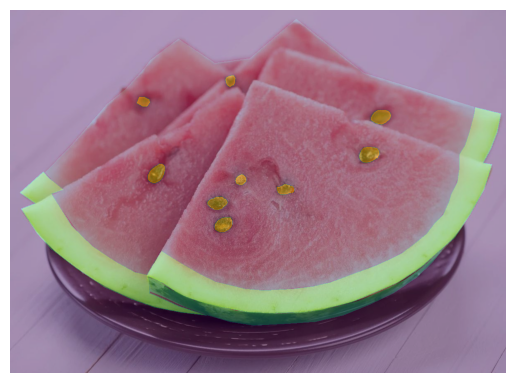

In [86]:
plt.imshow(img[:,:,::-1])
plt.imshow(mask[:,:,0], alpha=0.4) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

In [84]:
# 指定图像和标注路径
PATH_IMAGE = 'data/watermelon87_database/img_dir/train'
PATH_MASKS = 'data/watermelon87_database/ann_dir/train'

In [ ]:
# n行n列可视化
n = 5

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask[:,:,0], alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

# 准备config配置文件

In [1]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [2]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!touch mmseg/datasets/watermelon_dataset.py

In [4]:
!touch configs/_base_/datasets/watermelon_dataset_pipline.py

In [5]:
!touch configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon_dataset.py

In [3]:
from mmengine import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon_dataset.py')

In [4]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6
# cfg.model.decode_head.loss_decode = dict(type='FocalLoss', loss_weight=1.0)
# cfg.model.auxiliary_head.loss_decode = dict(type='FocalLoss', loss_weight=0.4)

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/watermelon'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [5]:
cfg.dump('pspnet-watermelon_20230612.py')

# MMSegmentation训练语义分割模型

In [6]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [7]:
import numpy as np

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine

In [8]:
from mmengine import Config
cfg = Config.fromfile('pspnet-watermelon_20230612.py')

In [9]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
/usr/

06/16 07:54:43 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.5 (default, Dec  9 2021, 17:04:37) [GCC 8.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.10.0+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


06/16 07:54:49 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/16 07:54:49 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [10]:
runner.train()
print('Completed train!')

06/16 07:54:49 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/16 07:54:50 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/16 07:54:50 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/16 07:54:50 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

06/16 07:54:50 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/16 07:54:50 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/16 07:54:50 - mmengine - INFO - Checkpoints will be saved to /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/work_dirs/watermelon.
06/16 07:54:58 - mmengine - INFO - Exp name: pspnet-watermelon_20230612_20230616_075443
06/16 07:54:58 - mmengi

# 测试集性能评估

In [1]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [2]:
!python tools/test.py pspnet-watermelon_20230612.py work_dirs/watermelon/iter_3000.pth

06/16 08:49:29 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.5 (default, Dec  9 2021, 17:04:37) [GCC 8.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.10.0+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

# 单张图像预测

In [1]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [2]:
!python demo/image_demo.py \
        "data/Watermelon87_Semantic_Seg_Mask/img_dir/val/OIP (11).jpeg" \
        pspnet-watermelon_20230612.py \
        work_dirs/watermelon/iter_3000.pth \
        --out-file "outputs/OIP (11).jpg" \
        --device cuda:0 \
        --opacity 0.5
!echo 'Completed!'

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
/usr/

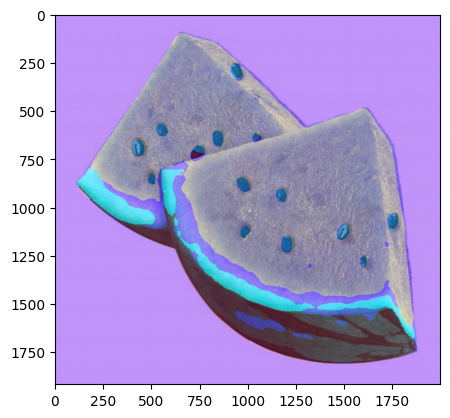

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Image.open('outputs/B1_uk_pspnet.jpg')
plt.imshow(Image.open('outputs/OIP (11).jpg'))

# 视频预测-Python API（推荐，快）

In [4]:
cd /project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation


In [5]:
!wget https://extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com/user-36511-files/b2fa2d82-f06e-4aa5-afaa-0d9e6c6862bc/pexels-watermelon.mp4 -P data/

--2023-06-16 09:08:21--  https://extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com/user-36511-files/b2fa2d82-f06e-4aa5-afaa-0d9e6c6862bc/pexels-watermelon.mp4
Resolving extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com (extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com)... 47.110.23.49
Connecting to extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com (extremevision-js-userfile.oss-cn-hangzhou.aliyuncs.com)|47.110.23.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5843290 (5.6M) [video/mp4]
Saving to: ‘data/pexels-watermelon.mp4.2’

pexels-watermelon.m 100%[===================>]   5.57M  8.30MB/s    in 0.7s    

2023-06-16 09:08:22 (8.30 MB/s) - ‘data/pexels-watermelon.mp4.2’ saved [5843290/5843290]



In [6]:
import numpy as np
import time
import shutil

import torch

from PIL import Image
import cv2

import mmcv
import mmengine
from mmseg.apis import inference_model
from mmseg.utils import register_all_modules
register_all_modules()

from mmseg.datasets import WatermelonDataset

/usr/local/lib/python3.7/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifi

In [7]:
import os

temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('创建临时文件夹 {} 用于存放每帧预测结果'.format(temp_out_dir))

创建临时文件夹 20230616090824 用于存放每帧预测结果


In [8]:
# 获取 Cityscapes 街景数据集 类别名和调色板
from mmseg.datasets import WatermelonDataset
classes = WatermelonDataset.METAINFO['classes']
palette = WatermelonDataset.METAINFO['palette']

In [9]:
def pridict_single_frame(img, opacity=0.2):
    result = inference_model(model, img)
    
    # 将分割图按调色板染色
    seg_map = np.array(result.pred_sem_seg.data[0].detach().cpu().numpy()).astype('uint8')
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    
    show_img = (np.array(seg_img.convert('RGB')))*(1-opacity) + img*opacity
    
    return show_img

In [10]:
from mmseg.apis import init_model

# 模型 config 配置文件
config_file = 'pspnet-watermelon_20230612.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'work_dirs/watermelon/iter_3000.pth'

model = init_model(config_file, checkpoint_file, device='cuda:0')

from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/project/train/src_repo/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


Loads checkpoint by local backend from path: work_dirs/watermelon/iter_3000.pth


In [ ]:
import cv2
input_video = 'data/pexels-watermelon.mp4'


# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmengine.ProgressBar(len(imgs))

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    img = cv2.resize(img, (512, 512))
    
    ## 处理单帧画面
    show_img = pridict_single_frame(img, opacity=0.15)
    temp_path = f'{temp_out_dir}/{frame_id:06d}.jpg' # 保存语义分割预测结果图像至临时文件夹
    cv2.imwrite(temp_path, show_img)

    prog_bar.update() # 更新进度条

# 把每一帧串成视频文件
mmcv.frames2video(temp_out_dir, 'outputs/watermelon_video.mp4', fps=imgs.fps, fourcc='mp4v')

shutil.rmtree(temp_out_dir) # 删除存放每帧画面的临时文件夹
print('删除临时文件夹', temp_out_dir)

[>>>>>>>>>>>>>>>>>>>>>>>       ] 174/221, 3.2 task/s, elapsed: 55s, ETA:    15s